(4799, 6)


/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


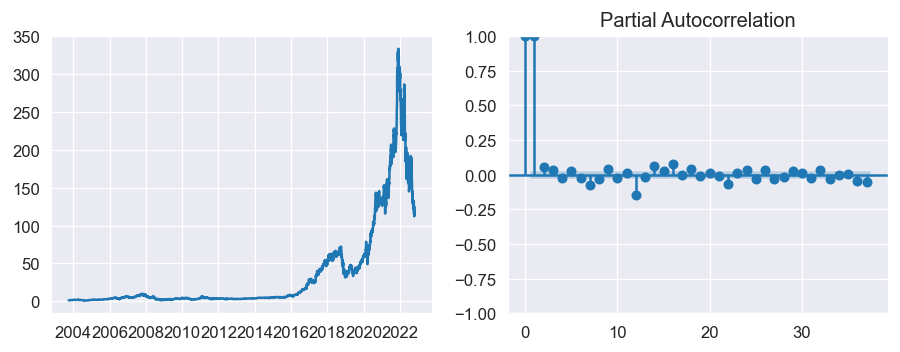

In [1]:
import pandas as pd
import numpy as py
import statsmodels.graphics.tsaplots
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df = pd.read_csv("./NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df_close = df['Close']
print(df.shape)
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_close)
plot_pacf(df_close, ax = axes[1])
plt.show()

# Step 1: Testing the time series for stationarity

First, we need to check if the time series is stationary. If it is, then no transformation is required.
Otherwise, we can make use of differencing to convert the time series to a stationary one so that ARIMA can predict on it.

To do this, we can make use of the Augmented Dickey-Fuller (ADF) test.

In [2]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_close)
print(f"ADFuller test p-value: {result[1]}")


ADFuller test p-value: 0.7781528039767531


## Interpretation of results

Note that the p-value of this test is 0.8819, which is much greater than the significance level of 0.05. Hence, we cannot reject the null hypothesis $H_0$ and we can conclude that the time series is not stationary.

As a result, we will need to conduct differencing in order to make the time series stationary.

In [3]:
from pmdarima.arima.utils import ndiffs

# Calculate the d term in the ARIMA model
ndiffs(df_close, test = "adf")

1

## Interpreting `ndiffs`

Note that `ndiffs` tells us that we only need order 1 differencing to make the time series stationary. Let's try this out:

New p-value for adfuller after 1st order differencing: 3.122982292496731e-23


/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


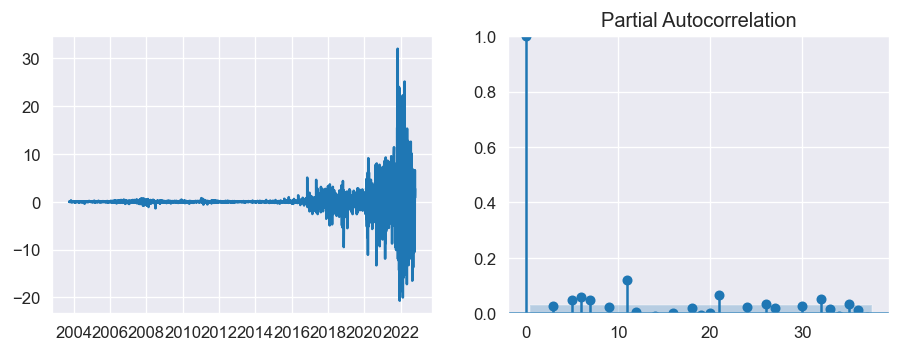

In [4]:
diff = df_close.diff().dropna()
new_p_value = adfuller(diff)[1]
print(f"New p-value for adfuller after 1st order differencing: {new_p_value}")
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff)
plot_pacf(diff, ax = axes[1])
axes[1].set_ylim(0, 1)
plt.show();

## Selecting a value for $p$ (autoregressive part)

Note that the new p-value for our adfuller test is very much smaller than 0.05, which gives us enough information to reject the null hypothesis and conclude that the time series is now stationary.

In the PACF plot, note that there is significant correlation above the significance line at lags 5, 6, 7 and 11. As a conservative estimate, let's take $p = 3$ for now.

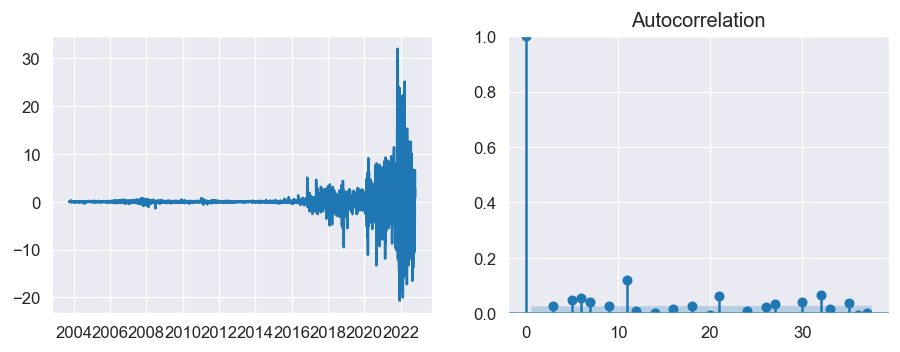

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff)
plot_acf(diff, ax = axes[1])
axes[1].set_ylim(0, 1)
plt.show()

## Selecting a value for $q$ (moving average part)

Note that once we have obtained values for $p$ and $d$, we now need to look at the ACF plot to see which lagged forecast errors might be significant. As seen in the plot, there appears to be significant correlation at 3, 5, 6, 7 and 11, but let's take $q$ = 3 for now as a conservative estimate.

# What's next?

Great! We now have values of $p,\ d,\ q$ required for our ARIMA model! So let's actually build that up and test it:

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

model = ARIMA(df_close, order = (3, 1, 13))
result = model.fit()
print(result.summary())

/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4799
Model:                ARIMA(3, 1, 13)   Log Likelihood              -10817.674
Date:                Sat, 22 Oct 2022   AIC                          21669.348
Time:                        15:40:49   BIC                          21779.439
Sample:                             0   HQIC                         21708.014
                               - 4799                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1071      0.029     -3.755      0.000      -0.163      -0.051
ar.L2          0.6028      0.030     19.915      0.000       0.543       0.662
ar.L3         -0.0776      0.027     -2.852      0.0

0    0.02598
dtype: float64


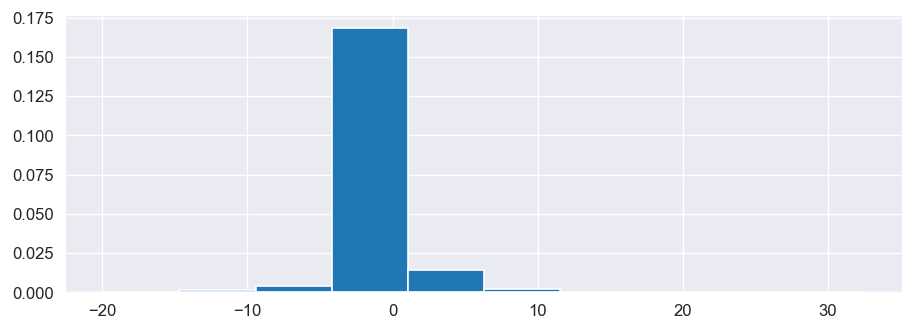

In [25]:
# Plot the residuals
residuals = pd.DataFrame(result.resid)
print(residuals.mean())

plt.hist(residuals, density = True);

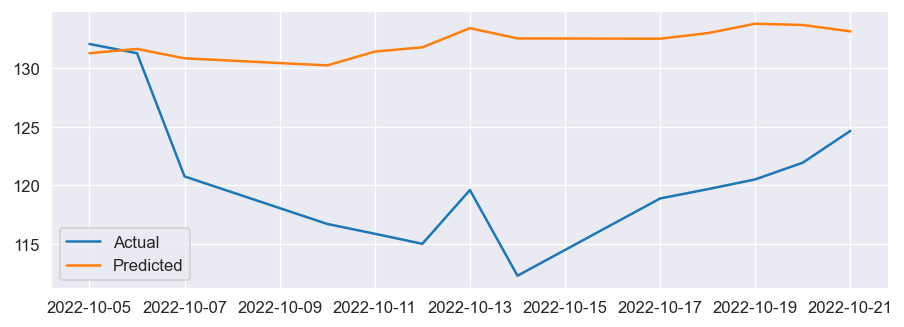

In [26]:
from statsmodels.graphics.tsaplots import plot_predict
df['Predict'] = result.predict(df.shape[0]-13, dynamic = True)
actual = df['Close'].iloc[df.shape[0]-13:]
plt.plot(actual, label = "Actual")
plt.plot(df[['Predict']], label = "Predicted")
plt.legend()
plt.show()

In [27]:
# model2 = pm.auto_arima(df['Close'], start_p = 1, start_q = 1, test = 'adf', max_p = 11,
#                       max_q = 11, seasonal = False, stepwise = True, trace = True)
# print(model2.summary())

In [34]:
# Actually make the predictions
predict = result.predict(df.shape[0], df.shape[0]+10, dynamic = True)
predict_df = pd.DataFrame(predict)
predict_df.to_csv("./ARIMApredict.csv")

/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
